# Explainable graph network for Graph Convolutional Networks for affordable epilepsy detection with EEG with affordable devices in Africa

Project developed as part of the Machine Learning for NeuroScience course during the winter semester 2024/25 at AGH University

Authors: Wojciech Burzak, Urszula Kicinger, Adam Staniszewski

The aim of the project was to create a graph convolutional network that detects epilepsy based on EEG data. After removing the interrupted EEGs, the dataset consists of 318 EEGs from Nigeria and Guinea-Bissau, measured using affordable devices.

The project was based on a project: https://github.com/szmazurek/sano_eeg.

Daatset: https://zenodo.org/records/1252141

## Library import

In [ ]:
!pip install pytorch-lightning
!pip install mne_features

In [1]:
# Library import

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

from scipy.signal import hilbert
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from mne_features.bivariate import compute_phase_lock_val

from sklearn.model_selection import train_test_split

# Metrics
from seaborn import heatmap
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# local import

from models import GATv2Lightning

## CUDA / CPU SETUP

In [3]:
# Choosing GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Data import

Data is imported from DATASET folder and labeled from data included in dataset's metadata.
Labels:
1 - epilepsy
0 - control group

In [97]:
# Defining basic labels and lists

eeg_points: list[str] = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
label_encoder: dict[str, int] = {
    'epilepsy' : 1,
    "control" : 0
}

studies: list[pd.Series] = []
labels: list[int] = []

In [98]:
# Loading metadata from Guinea Bissau

meta_gb = pd.read_csv("DATASET/metadata_guineabissau.csv")

In [99]:
def get_closed_eyes_signal(signal: pd.DataFrame) -> pd.DataFrame:
    """ A function that crops the given EEG signal """
    num_rows: int = len(signal)
    return signal[int(3 * num_rows / 5):]

In [100]:
# Preprocessing data from Guinea Bissau

for row in meta_gb.iterrows():
    subject_id = row[1]['subject.id']
    # Getting label - Epilepsy(1) / Control(0)
    label = label_encoder[row[1].Group.lower()]

    # Uploading and preprocessing EEG
    signal = pd.read_csv(f"DATASET/EEGs_Guinea-Bissau/signal-{subject_id}.csv")
    signal = signal[eeg_points]
    closed_eyes_signal = get_closed_eyes_signal(signal)

    studies.append(closed_eyes_signal)
    labels.append(label)

In [101]:
# Loading metadata from Nigeria

meta_nig = pd.read_csv("DATASET/metadata_nigeria.csv")

In [102]:
# Preprocessing data from Nigeria

for _, row in meta_nig.iterrows():
    subject_id = row['subject.id']
    label = label_encoder[row.Group]
    filename = row['csv.file'][:-3]
    signal = pd.read_csv(f"DATASET/EEGs_Nigeria/{filename}")
    signal = signal[eeg_points]
    
    closed_eyes_signal = get_closed_eyes_signal(signal)

    studies.append(closed_eyes_signal)
    labels.append(label)

In [103]:
print(f"Number of EEGs: {len(studies)}")

Number of EEGs: 318


In [104]:
studies[0]

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8
23116,4064.615385,3748.717949,4046.666667,3572.307692,3704.102564,3573.333333,4488.717949,3920.000000,4103.589744,4070.256410,3877.435897,3985.128205,3700.000000,3803.076923
23117,4057.948718,3738.461538,4038.974359,3564.102564,3708.717949,3560.000000,4483.589744,3908.205128,4103.076923,4061.025641,3870.256410,3976.923077,3695.384615,3792.307692
23118,4050.769231,3729.230769,4032.820513,3554.871795,3706.666667,3554.871795,4475.384615,3905.128205,4102.564103,4061.025641,3862.051282,3971.794872,3689.230769,3787.179487
23119,4048.205128,3730.256410,4032.820513,3555.897436,3706.153846,3565.128205,4476.923077,3909.743590,4104.102564,4069.230769,3868.205128,3979.487179,3689.743590,3793.846154
23120,4054.358974,3742.051282,4042.564103,3568.205128,3716.923077,3575.384615,4487.692308,3920.000000,4111.794872,4076.410256,3878.974359,3989.230769,3696.923077,3803.589744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38523,4049.230769,3826.666667,4003.589744,3550.256410,4229.230769,3572.307692,4376.923077,3721.025641,4197.435897,4053.846154,3893.846154,3973.846154,3681.025641,3817.948718
38524,4056.410256,3832.307692,4002.051282,3554.358974,4230.769231,3575.897436,4375.897436,3724.102564,4198.974359,4051.282051,3894.871795,3972.820513,3685.128205,3818.461538
38525,4060.512821,3835.897436,4006.666667,3561.538462,4233.846154,3574.871795,4367.692308,3726.153846,4199.487179,4052.820513,3894.358974,3970.769231,3685.128205,3813.846154
38526,4052.820513,3827.179487,4006.666667,3559.487179,4229.230769,3571.282051,4372.307692,3723.589744,4198.461538,4054.358974,3891.282051,3970.256410,3681.025641,3814.358974


## Converting EEG to PLV matrix

Each EEG will be represented as a connection matrix between electrodes. Later it will be converted to graphs, where each electrode is a node and a PLV value will be an edge value.

In [105]:
def compute_plv(matrix, columns):
    """ A function that calculates PLV matrix from given matrix """
    n_channels = matrix.shape[1]
    plv_matrix = np.zeros((n_channels, n_channels))

    phases = np.angle(hilbert(matrix, axis=0))
    for i in range(n_channels):
        for j in range(n_channels):
            phase_diff = phases[:, i] - phases[:, j]
            plv_matrix[i, j] = np.abs(np.mean(np.exp(1j * phase_diff)))

    return pd.DataFrame(plv_matrix, columns=columns, index=columns)


def compute_plv_v2(matrix, columns):
    """ A function that calculates PLV matrix from given matrix
    Source: github.com/szmazurek/sano_eeg"""
    matrix = matrix.T

    plv_conn_vector = compute_phase_lock_val(matrix)

    n = int(np.sqrt(2 * len(plv_conn_vector))) + 1

    # Reshape the flattened array into a square matrix
    upper_triangular = np.zeros((n, n))
    upper_triangular[np.triu_indices(n, k=1)] = plv_conn_vector

    # Create an empty matrix for the complete symmetric matrix
    symmetric_matrix = np.zeros((n, n))

    # Fill the upper triangular part (including the diagonal)
    symmetric_matrix[np.triu_indices(n)] = upper_triangular[np.triu_indices(n)]

    # Fill the lower triangular part by mirroring the upper triangular
    plv_matrix = (
        symmetric_matrix
        + symmetric_matrix.T
        - np.diag(np.diag(symmetric_matrix))
    )

    # Add 1 to the diagonal elements
    np.fill_diagonal(plv_matrix, 1)
    return pd.DataFrame(plv_matrix, columns=columns, index=columns)

In [106]:
# Converting each EEG signal to PLV matrix

for i, study in enumerate(studies):
    studies[i] = compute_plv_v2(study.values, study.columns)

In [107]:
# Checking if all EEGs where converted to connection matrix

assert len(studies) == 318

In [108]:
# for i, study in enumerate(studies):
#     study.to_csv(f"study_{i}.csv", index=False)

## Preparing dataloader for the models

In [109]:
# Splitting dataset for training, validation and test subsets

train_studies, temp_studies, train_labels, temp_labels = train_test_split(studies, labels, test_size=0.2, random_state=42, stratify=labels)
valid_studies, test_studies, valid_labels, test_labels = train_test_split(temp_studies, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

print(f"Train size: {len(train_studies)}")
print(f"Validation size: {len(valid_studies)}")
print(f"Test size: {len(test_studies)}")

Train size: 254
Validation size: 32
Test size: 32


In [110]:
def cast_study_to_graph(study):
    """ A function that casts EEGs connection matrix into graph data structure """
    x = torch.tensor(study.values, dtype=torch.float)
    num_nodes = x.size(0)
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()  
    edge_attr = torch.ones(edge_index.size(1), dtype=torch.float) 
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return data

In [111]:
def add_masks(data, train_ratio=0.6, val_ratio=0.2):
    """ A function that creates masks in a dataset splitting it to training, validation and test subsets """
    num_nodes = data.x.size(0)
    indices = torch.randperm(num_nodes)

    train_size = int(train_ratio * num_nodes)
    val_size = int(val_ratio * num_nodes)

    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[indices[:train_size]] = 1
    data.val_mask[indices[train_size:train_size + val_size]] = 1
    data.test_mask[indices[train_size + val_size:]] = 1

    return data

In [112]:
def add_target_labels(data, i, labels):
    """ A function that defines a target class for a graph (Epilepsy or Control) """
    num_nodes = data.x.size(0)
    if labels[i] == 0:
        data.y = torch.zeros((num_nodes,))
    else:
        data.y = torch.ones((num_nodes,))
    return data

Creating a dataset in a following steps:
1) Cast PLV matrix from to graph structure (function: cast_study_to_graph)
2) Split whole dataset into train, validation and test subsets by applying masks (function: add_masks)
3) Add target labels to each graph
4) Create DataLoader for training model

In [113]:
train_graph_dataset = [cast_study_to_graph(study) for study in train_studies]
train_graph_dataset = [add_target_labels(data, i, train_labels) for i, data in enumerate(train_graph_dataset)]

train_loader = DataLoader(train_graph_dataset, batch_size=32, shuffle=True)

In [114]:
val_graph_dataset = [cast_study_to_graph(study) for study in valid_studies]
val_graph_dataset = [add_target_labels(data, i, valid_labels) for i, data in enumerate(val_graph_dataset)]

valid_loader = DataLoader(val_graph_dataset, batch_size=32, shuffle=True)

In [115]:
test_graph_dataset = [cast_study_to_graph(study) for study in test_studies]
test_graph_dataset = [add_target_labels(data, i, test_labels) for i, data in enumerate(test_graph_dataset)]

test_loader = DataLoader(test_graph_dataset, batch_size=32, shuffle=True)

### Exemplary graph visualisation

In this graph nodes are electrodes and edges weigths are plv values between measurements frm this electrodes.

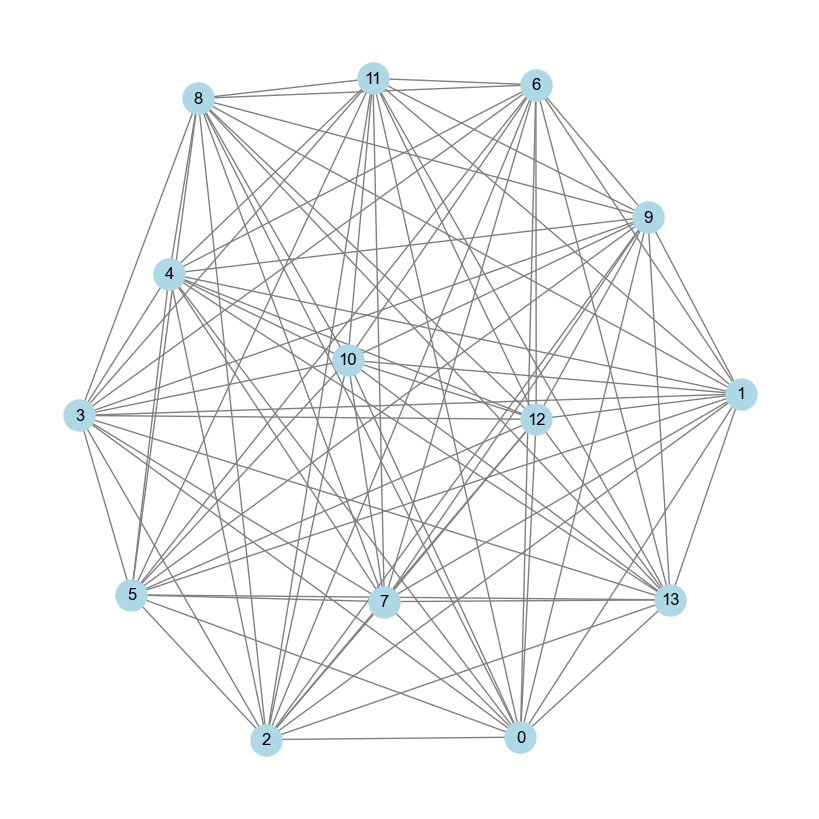

In [116]:
train_sample = train_graph_dataset[6]
G = to_networkx(train_sample, to_undirected=True)

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.show()

## Building model

In [117]:
# Defining model configs

in_features = 14  # Number of input features per node
n_gat_layers = 2  # Number of GAT layers
hidden_dim = 16  # Number of hidden units per attention head
n_heads = 4  # Number of attention heads
dropout = 0.5  # Dropout rate
slope = 0.2  # LeakyReLU slope
pooling_method = 'mean'  # Pooling method 
activation = 'relu'  # Activation function
norm_method = None  # Normalization method 
n_classes = 2  # Number of output classes
lr = 0.001  # Learning rate
weight_decay = 5e-4  # Weight decay

In [118]:
# Defining the model

model = GATv2Lightning(in_features, n_gat_layers, hidden_dim, n_heads, dropout, slope,
                       pooling_method, activation, norm_method, n_classes-1, lr, weight_decay)

In [129]:
# Defining model training configs

optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
criterion = nn.CrossEntropyLoss()

## Training model

In [120]:
def train():
    """ A function that trains a previously defined model """
    model.train()
    total_loss = 0
    for data in train_loader:
        # print(f'Training data.x shape: {data.x.shape}')
        # print(f'Training data.edge_index shape: {data.edge_index.shape}')
        # print(f'Training data.y shape: {data.y.shape}')
        # print(f'Training data.train_mask shape: {data.train_mask.shape}')
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        # print(f'Training output shape: {out.shape}')
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / (14 * len(train_loader.dataset))

In [121]:
def validate():
    """ A function that validates a previously defined model """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in valid_loader:
            # print(f'Validation data.x shape: {data.x.shape}')
            # print(f'Validation data.edge_index shape: {data.edge_index.shape}')
            # print(f'Validation data.y shape: {data.y.shape}')
            # print(f'Validation data.val_mask shape: {data.val_mask.shape}')
            out = model(data.x, data.edge_index)
            # print(f'Validation output shape: {out.shape}')
            loss = criterion(out.squeeze(), data.y)
            total_loss += loss.item() * data.num_graphs
    return total_loss / (14 * len(valid_loader.dataset))

In [122]:
EPOCHS = 100

In [123]:
learning_history = []

for epoch in range(EPOCHS):
    train_loss = train()
    val_loss = validate()
    scheduler.step(val_loss)
    learning_history.append([train_loss, val_loss])
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1, Train Loss: 110.0065, Val Loss: 109.8696
Epoch 2, Train Loss: 109.2429, Val Loss: 109.8598
Epoch 3, Train Loss: 108.9820, Val Loss: 109.8619
Epoch 4, Train Loss: 109.3667, Val Loss: 109.8962
Epoch 5, Train Loss: 109.1368, Val Loss: 109.9080
Epoch 6, Train Loss: 109.0690, Val Loss: 109.8943
Epoch 7, Train Loss: 109.1264, Val Loss: 109.8884
Epoch 8, Train Loss: 109.2852, Val Loss: 109.8844
Epoch 9, Train Loss: 109.1648, Val Loss: 109.8719
Epoch 10, Train Loss: 108.9315, Val Loss: 109.8503
Epoch 11, Train Loss: 109.3739, Val Loss: 109.8347
Epoch 12, Train Loss: 109.2720, Val Loss: 109.8325
Epoch 13, Train Loss: 109.2325, Val Loss: 109.8286
Epoch 14, Train Loss: 109.1300, Val Loss: 109.8070
Epoch 15, Train Loss: 109.0342, Val Loss: 109.7970
Epoch 16, Train Loss: 108.9388, Val Loss: 109.8115
Epoch 17, Train Loss: 108.8829, Val Loss: 109.8086
Epoch 18, Train Loss: 109.0386, Val Loss: 109.7836
Epoch 19, Train Loss: 108.9491, Val Loss: 109.7702
Epoch 20, Train Loss: 108.6747, Val Loss

### Training history plot

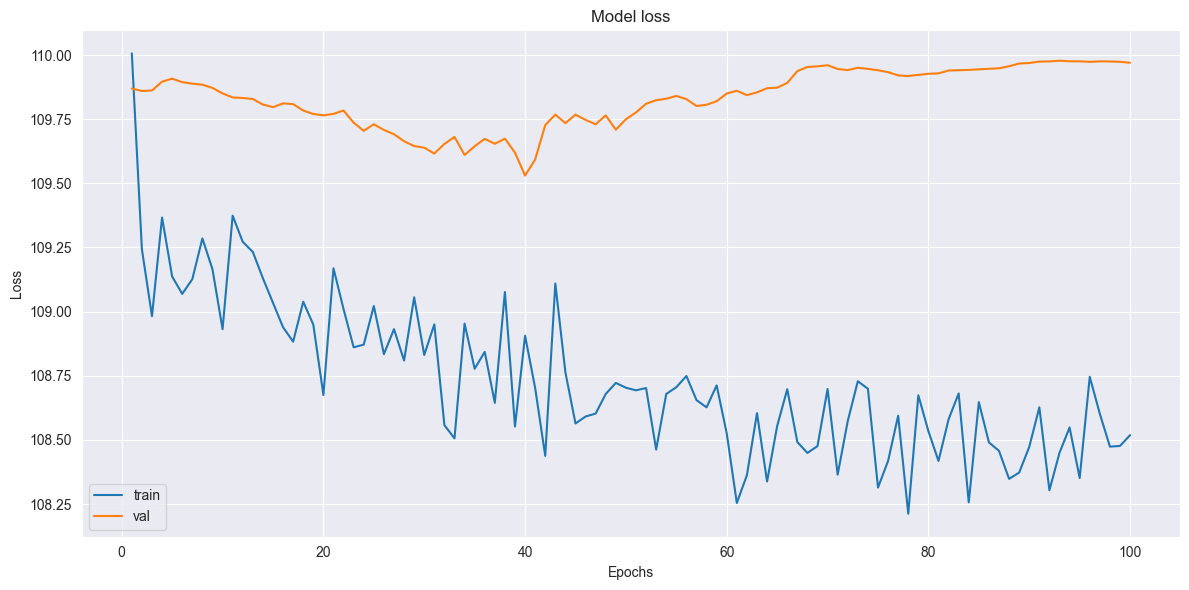

In [124]:
learning_history = np.array(learning_history)
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.arange(EPOCHS) + 1, learning_history[:, 0], label='train')
ax.plot(np.arange(EPOCHS) + 1, learning_history[:, 1], label='val')

ax.set_title('Model loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

plt.legend()

plt.tight_layout()
plt.show()

## Model evaluation

Evaluating model on test dataset

### Metrics

In [125]:
# Calculating model outputs on test dataset
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index).squeeze()
        y_true = data.y
        y_pred = out

# Making class predictions
y_pred = y_pred > 0

#### Confusion matrix

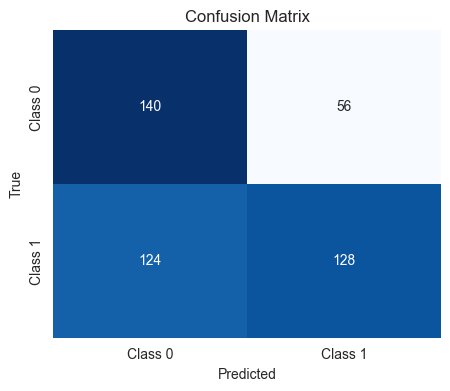

In [126]:
# Calculating confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(5, 4))
heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Accuracy, precision, recall, F1-score

In [127]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Precision
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.2f}")

# Recall
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.2f}")

# F1 Score
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.60
Precision: 0.70
Recall: 0.51
F1 Score: 0.59


#### AUC_ROC

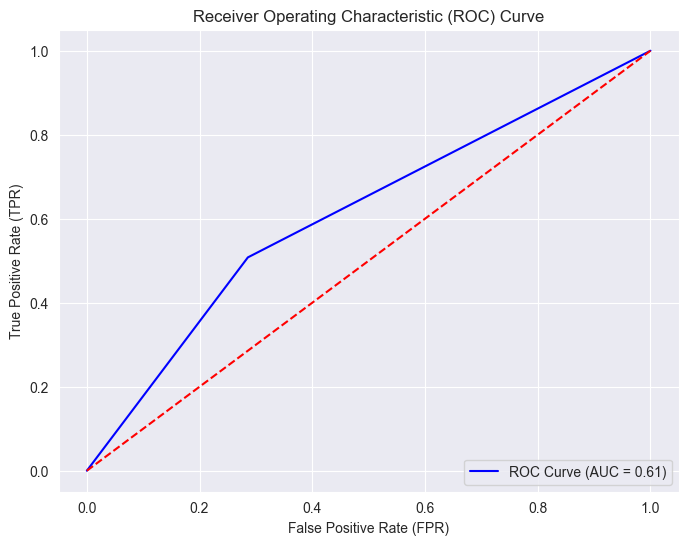

AUC Score: 0.61


In [128]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Computing the AUC (Area Under the Curve)
auc = roc_auc_score(y_true, y_pred)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')  # Random classifier line (diagonal)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Printing AUC score
print(f"AUC Score: {auc:.2f}")